# Classifying The Habeerman Dataset

When complete, I will review your code, so please submit your code via pull-request to the [Introduction to Machine Learning with Scikit-Learn](https://github.com/georgetown-analytics/machine-learning) repository!

## Habeerman Kernel Example

Downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data) on August 24, 2016. The first thing is to fully describe your data in a README file. The dataset description is as follows:

- Data Set: Multivariate
- Attribute: Real
- Tasks: Classification, Clustering
- Instances: 210
- Attributes: 7

### Data Set Information:

The dataset contains cases from a study that was conducted between 1958 and 1970 at the University of Chicago's Billings Hospital on the survival of patients who had undergone surgery for breast cancer.

The data set can be used for the tasks of classification and cluster analysis.

### Attribute Information:

Below are the attributes:

1. Age of patient at time of operation (numerical)
2. Patient's year of operation (year - 1900, numerical)
3. Number of positive axillary nodes detected (numerical)
4. Survival status (class attribute)
    1 = the patient survived 5 years or longer
    2 = the patient died within 5 year



## Data Exploration 

In this section we will begin to explore the dataset to determine relevant information.

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"

def fetch_data(fname='habeerman.data'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'w') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data()
print(DATA)

C:\Users\pbw50\machine-learning\notebook\habeerman.data


In [3]:
FEATURES  = [
    "Age",
    "year",
    "nodes",  
    "label"
]
LABEL_MAP = {
    1: "Survived",
    2: "Died",
  
}

# Read the data into a DataFrame
df = pd.read_csv(DATA,  header=None, names=FEATURES)
print(df.head())
# Convert class labels into text
for k,v in LABEL_MAP.items():
    df.ix[df.label == k, 'label'] = v
print(df.label.unique())
#check label values
print(df.head())
    
    
# Describe the dataset
print df.describe()

   Age  year  nodes  label
0   30    64      1      1
1   30    62      3      1
2   30    65      0      1
3   31    59      2      1
4   31    65      4      1
['Survived' 'Died']
   Age  year  nodes     label
0   30    64      1  Survived
1   30    62      3  Survived
2   30    65      0  Survived
3   31    59      2  Survived
4   31    65      4  Survived
              Age        year       nodes
count  306.000000  306.000000  306.000000
mean    52.457516   62.852941    4.026144
std     10.803452    3.249405    7.189654
min     30.000000   58.000000    0.000000
25%     44.000000   60.000000    0.000000
50%     52.000000   63.000000    1.000000
75%     60.750000   65.750000    4.000000
max     83.000000   69.000000   52.000000


In [4]:
# Determine the shape of the data
print "{} instances with {} features\n".format(*df.shape)
#I believe the shape includes the lables. 
# Determine the frequency of each class
print df.groupby('label')['label'].count()

306 instances with 4 features

label
Died         81
Survived    225
Name: label, dtype: int64


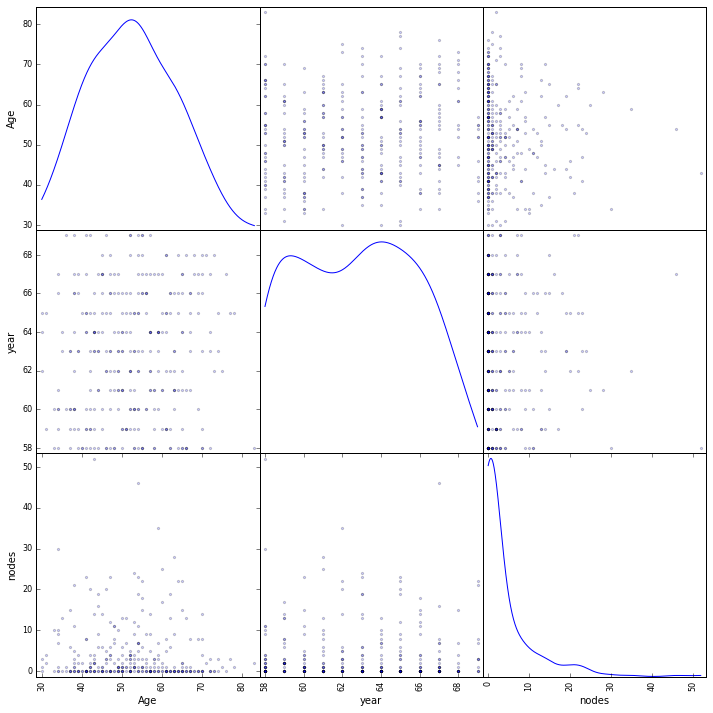

In [5]:
# Create a scatter matrix of the dataframe features
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

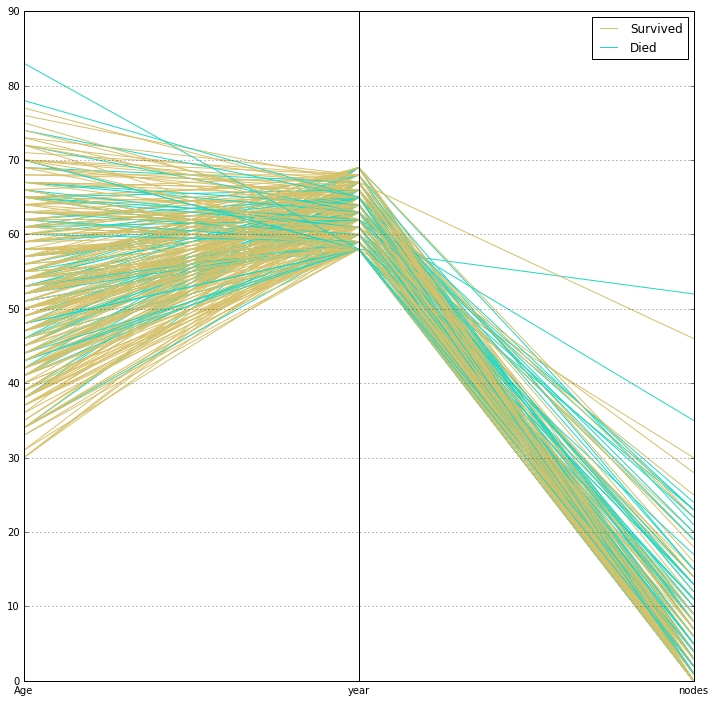

In [6]:
from pandas.tools.plotting import parallel_coordinates
plt.figure(figsize=(12,12))
parallel_coordinates(df, 'label')
plt.show()

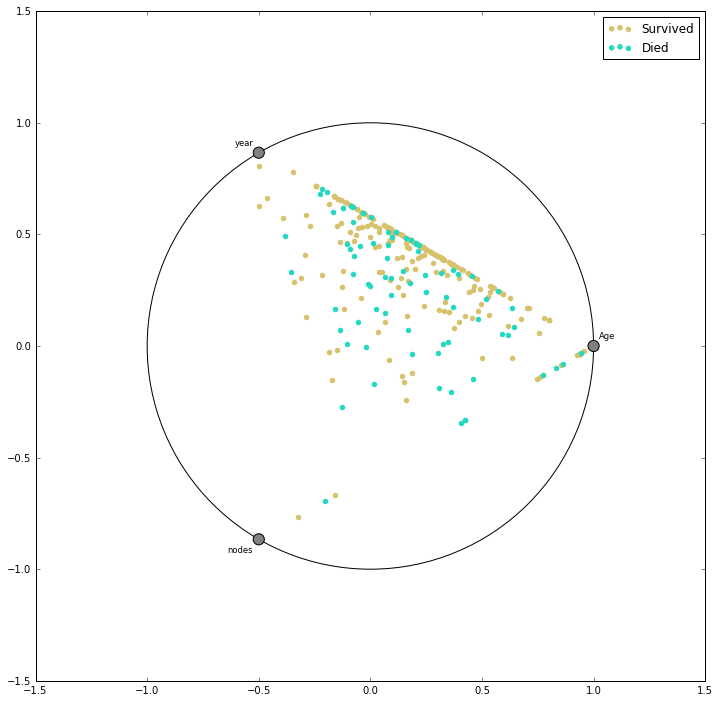

In [7]:
from pandas.tools.plotting import radviz
plt.figure(figsize=(12,12))
radviz(df, 'label')
plt.show()

## Data Extraction 

One way that we can structure our data for easy management is to save files on disk. The Scikit-Learn datasets are already structured this way, and when loaded into a `Bunch` (a class imported from the `datasets` module of Scikit-Learn) we can expose a data API that is very familiar to how we've trained on our toy datasets in the past. A `Bunch` object exposes some important properties:

- **data**: array of shape `n_samples` * `n_features`
- **target**: array of length `n_samples`
- **feature_names**: names of the features
- **target_names**: names of the targets
- **filenames**: names of the files that were loaded
- **DESCR**: contents of the readme

**Note**: This does not preclude database storage of the data, in fact - a database can be easily extended to load the same `Bunch` API. Simply store the README and features in a dataset description table and load it from there. The filenames property will be redundant, but you could store a SQL statement that shows the data load. 

In order to manage our data set _on disk_, we'll structure our data as follows:

In [8]:
from sklearn.datasets.base import Bunch

DATA_DIR = os.path.abspath(os.path.join(".", "..", "data",'habeerman'))
#C:\Users\pbw50\machine-learning\notebook\habeerman.data
# Show the contents of the data directory
for name in os.listdir(DATA_DIR):
    if name.startswith("."): continue
    print "- {}".format(name)

- habeerman.data
- meta.json
- README.md


In [9]:
def load_data(root=DATA_DIR):
    # Construct the `Bunch` for the habeerman dataset
    filenames     = {
        'meta': os.path.join(root, 'meta.json'),
        'rdme': os.path.join(root, 'README.md'),
        'data': os.path.join(root, 'habeerman.data'),
        
    }
    
    #Load the meta data from the meta json
    with open(filenames['meta'], 'r') as f:
        meta = json.load(f)        
        target_names  = meta['target_names']
        feature_names = meta['feature_names']
       

    # Load the description from the README. 
    with open(filenames['rdme'], 'r') as f:
        DESCR = f.read()
        

    # Load the dataset from the data  file.
    dataset = pd.read_csv(filenames['data'], header=None)
    #tranform to numpy
    data1   = dataset.ix[:, 0:2] 
    target1 = dataset.ix[:,3]
    
    # Extract the target from the data
    data   = np.array(data1)   
    target = np.array(target1)

    # Create the bunch object
    return Bunch(
        data=data,
        target=target,
        filenames=filenames,
        target_names=target_names,
        feature_names=feature_names,
        DESCR=DESCR
    )

# Save the dataset as a variable we can use.
dataset = load_data()

print dataset.data.shape
print dataset.target.shape

(306L, 3L)
(306L,)


## Classification 

Now that we have a dataset `Bunch` loaded and ready, we can begin the classification process. Let's attempt to build a classifier with kNN, SVM, and Random Forest classifiers. 

In [10]:
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import KFold

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [24]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    for train, test in KFold(dataset.data.shape[0], n_folds=12, shuffle=True):
        X_train, X_test = dataset.data[train], dataset.data[test]
        y_train, y_test = dataset.target[train], dataset.target[test]
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="binary"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="binary"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="binary"))

    # Report
    print "Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start)
    print "Validation scores are as follows:\n"
    print pd.DataFrame(scores).mean()
    
    # Write official estimator to disk
    estimator = model(**kwargs)
    estimator.fit(dataset.data, dataset.target)
    
    outpath = label.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'w') as f:
        pickle.dump(estimator, f)

    print "\nFitted model written to:\n{}".format(os.path.abspath(outpath))

In [25]:
# Perform SVC Classification
fit_and_evaluate(dataset, SVC, "habeerman SVM Classifier", )

Build and Validation of habeerman SVM Classifier took 0.137 seconds
Validation scores are as follows:

accuracy     0.737821
f1           0.844473
precision    0.737714
recall       0.994444
dtype: float64

Fitted model written to:
C:\Users\pbw50\machine-learning\notebook\habeerman-svm-classifier.pickle


In [26]:
# Perform kNN Classification
fit_and_evaluate(dataset, KNeighborsClassifier, "habeerman kNN Classifier", n_neighbors=12)

Build and Validation of habeerman kNN Classifier took 0.041 seconds
Validation scores are as follows:

accuracy     0.763590
f1           0.849247
precision    0.778242
recall       0.945352
dtype: float64

Fitted model written to:
C:\Users\pbw50\machine-learning\notebook\habeerman-knn-classifier.pickle


In [27]:
# Perform Random Forest Classification
fit_and_evaluate(dataset, RandomForestClassifier, "habeerman Random Forest Classifier")

Build and Validation of habeerman Random Forest Classifier took 0.321 seconds
Validation scores are as follows:

accuracy     0.686282
f1           0.794773
precision    0.765743
recall       0.832906
dtype: float64

Fitted model written to:
C:\Users\pbw50\machine-learning\notebook\habeerman-random-forest-classifier.pickle
